In [27]:
%matplotlib inline
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import urllib.request
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from tqdm import tqdm
from copy import deepcopy
pylab.rcParams['figure.figsize'] = (8.0, 10.0)


In [28]:
import functools
import os.path
import random
import sys
import xml.etree.ElementTree
import numpy as np
import matplotlib.pyplot as plt
import skimage.data
import cv2
import PIL.Image

In [29]:
import os
import random
from argparse import ArgumentParser
from PIL import Image

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.utils as vutils

from model.networks import Generator
from utils.tools import get_config, random_bbox, mask_image, is_image_file, default_loader, normalize, get_model_list

SEED = 42 

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


In [30]:
from pathlib import Path
from glob import glob
import json

In [31]:
dataDir='datasets/coco'
dataType='val2017'
annFile_full='{}/annotations/instances_{}.json'.format(dataDir,dataType)
annFile_human_pose = '{}/annotations/person_keypoints_{}.json'.format(dataDir,dataType)

In [32]:
# initialize COCO api for instance annotations
coco=COCO(annFile_full)
coco_kps=COCO(annFile_human_pose)

# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person'])
imgIds = coco.getImgIds(catIds=catIds)

list_of_anns = []
for img_id in imgIds:
    img = coco.loadImgs(img_id)[0]
    annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=0)
    if len(annIds) != 1:
        continue
    anns = coco_kps.loadAnns(annIds)
    if anns[0]['area'] < 3000:
        continue
    
    if anns[0]['num_keypoints'] < 10:
        continue
    list_of_anns.append(anns[0])

loading annotations into memory...
Done (t=0.51s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [33]:
def show_img_and_anno_from_array(arr, anns, coco_kps):
    plt.figure(figsize=(10,10))    
    print(' -------------- img object -------------- ')
    # load and display img
    plt.imshow(arr)
    # load and display keypoints annotations
    #plt.imshow(I)
    plt.axis('off')
    ax = plt.gca()
    coco_kps.showAnns(anns)
    plt.show()

def process_results(results):
    ''' Porcess results '''
    final_res = []
    set_ids = []
    for i, img in enumerate(results):
        
        IDs = img['image_id']
        if IDs in set_ids:
            continue
        image_id = IDs.split('.')[0]
        ann_id = IDs.split('.')[1]
        
        img['image_id'] = int(image_id)
        img['id'] = int(ann_id)
        img['bbox'] = []
        
        final_res.append(img)
        set_ids.append(IDs)
        
    return final_res, set(set_ids)

def get_the_paths(folder_path):
    return sorted([str(file).split('/')[1] for file in Path(folder_path).glob('*.jpg')])

def get_shared_ids(real_list, occ_list, gen_list):
    return set(real_list).intersection(set(occ_list),set(gen_list))

def remove_unshared_img(list_imgs, large_list):
    return [x for x in large_list if x in list_imgs]

def remove_unshared_img_res(list_imgs, large_list):
        check_list = list(list_imgs)
        check_list = [int(x.split('.')[0]) for x in check_list]
        return [x for x in large_list if x['image_id'] in check_list]

class DataLoader:
    ''' Table to load the Data from folders '''
    def __init__(self,
                 real_img_path,
                 occ_img_path,
                 gen_img_path,
                 res_path,
                 ls_gt,
                 ):
        ''' Define the constructor variables'''
        self.real_img_path = real_img_path
        self.occ_img_path = occ_img_path
        self.gen_img_path = gen_img_path
        self.res_path = res_path
        self.ls_gt = ls_gt
    
    def load_json(self, path):
        with open(os.path.join(self.res_path,f'alphapose-{path}-results.json')) as f:
            results = json.load(f)
        return process_results(results)
    
    def create_dictionary_of_lists(self, real_list, real_results, cocoDt_real, occ_list, occ_results, cocoDt_occ, gen_list, gen_results, cocoDt_gen, final_ls_gt, cocoGt, annType):
        final_dict = {}
        for i, img_ann_ids in enumerate(real_list):
            image_id = img_ann_ids.split('.')[0]
            results_dict = {}
            for key in ['real', 'occ', 'gen', 'gt']:
                if key == 'gt':
                    results_dict[key] = final_ls_gt[i]
                    
                if key == 'real':
                    # running evaluation
                    cocoEval = COCOeval(cocoGt,cocoDt_real,annType)
                    cocoEval.params.imgIds  = int(image_id)
                    cocoEval.evaluate()
                    cocoEval.accumulate()
                    cocoEval.summarize()
                    results_dict[key] = [os.path.join(self.real_img_path,real_list[i]), real_results[i], cocoEval.stats]
                    
                if key == 'occ':
                    # running evaluation
                    cocoEval = COCOeval(cocoGt,cocoDt_occ,annType)
                    cocoEval.params.imgIds  = int(image_id)
                    cocoEval.evaluate()
                    cocoEval.accumulate()
                    cocoEval.summarize()
                    results_dict[key] = [os.path.join(self.occ_img_path,occ_list[i]), occ_results[i], cocoEval.stats]
                    
                if key == 'gen':
                    # running evaluation
                    cocoEval = COCOeval(cocoGt,cocoDt_gen,annType)
                    cocoEval.params.imgIds  = int(image_id)
                    cocoEval.evaluate()
                    cocoEval.accumulate()
                    cocoEval.summarize()
                    results_dict[key] = [os.path.join(self.gen_img_path,gen_list[i]), gen_results[i], cocoEval.stats]
                    
            final_dict[int(image_id)] = results_dict
            
        return final_dict
        
    def make_dataset(self):
        # Get the lists of folder path img
        real_imgs_paths = get_the_paths(self.real_img_path)
        occ_imgs_paths = get_the_paths(self.occ_img_path)
        gen_imgs_paths = get_the_paths(self.gen_img_path)
        
        # Get list of results paths
        real_results, res_set = self.load_json('real')
        occ_results, res_occ = self.load_json('occ')
        gen_results, res_gen = self.load_json('gen')
        
        # Get shared list
        shared_img = get_shared_ids(real_imgs_paths, 
                                    occ_imgs_paths,
                                    gen_imgs_paths)

        # Get shared list
        shared_results_ids = get_shared_ids(res_set, 
                                            res_occ,
                                            res_gen)
        
        # get final image ids
        shared_img = shared_img.intersection(shared_results_ids)
        
        # Check if unwanted files are present
        real_imgs_paths = remove_unshared_img(shared_img,
                                              real_imgs_paths)
        occ_imgs_paths = remove_unshared_img(shared_img,
                                             occ_imgs_paths)
        gen_imgs_paths = remove_unshared_img(shared_img,
                                             gen_imgs_paths)
        final_ls_gt = remove_unshared_img_res(shared_img,
                                              self.ls_gt)
        real_results = remove_unshared_img_res(shared_img,
                                              real_results)
        occ_results = remove_unshared_img_res(shared_img,
                                              occ_results)
        gen_results = remove_unshared_img_res(shared_img,
                                              gen_results)
        
        # Sort anns list of dict
        final_ls_gt = sorted(final_ls_gt, key=lambda k: str(k['image_id']))
        real_results = sorted(real_results, key=lambda k: str(k['image_id']))
        occ_results = sorted(occ_results, key=lambda k: str(k['image_id']))
        gen_results = sorted(gen_results, key=lambda k: str(k['image_id']))
        
        print(' ------------- Check img Length ------------- ')
        print(f'Real list : {len(real_imgs_paths)}\nOccluded list : {len(occ_imgs_paths)}\nGenerated list : {len(gen_imgs_paths)}\nGround Thruth list : {len(final_ls_gt)}')
        
        print(' ------------- Check results Length ------------- ')
        print(f'Real results : {len(real_results)}\nOccluded results : {len(occ_results)}\nGenerated results : {len(gen_results)}\nShared results : {len(shared_img)}')
        
        # Get Eval accuracy
        annType = ['segm','bbox','keypoints']
        annType = annType[2]      #specify type here
        prefix = 'person_keypoints' if annType=='keypoints' else 'instances'
        print ('Running demo for *%s* results.'%(annType))
        
        #initialize COCO ground truth api
        dataDir='datasets/coco'
        dataType='val2017'
        annFile = '%s/annotations/%s_%s.json'%(dataDir,prefix,dataType)
        print(annFile)
        cocoGt=COCO(annFile)

        cocoDt_real=cocoGt.loadRes(real_results)
        cocoDt_occ=cocoGt.loadRes(occ_results)
        cocoDt_gen=cocoGt.loadRes(gen_results)
        
        return self.create_dictionary_of_lists(real_imgs_paths, 
                                               real_results,
                                               cocoDt_real,
                                               occ_imgs_paths, 
                                               occ_results,
                                               cocoDt_occ,
                                               gen_imgs_paths, 
                                               gen_results, 
                                               cocoDt_gen,
                                               final_ls_gt,
                                               cocoGt,
                                               annType,
                                              ), list(shared_img)

In [34]:
loader = DataLoader('real_img', 'occ_img', 'gen_img', 'results/coco/val2017', list_of_anns)
dataset, image_ids = loader.make_dataset()
image_ids = [int(ids.split('.')[0]) for ids in image_ids]

 ------------- Check img Length ------------- 
Real list : 543
Occluded list : 543
Generated list : 543
Ground Thruth list : 543
 ------------- Check results Length ------------- 
Real results : 543
Occluded results : 543
Generated results : 543
Shared results : 543
Running demo for *keypoints* results.
datasets/coco/annotations/person_keypoints_val2017.json
loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
Loading and preparing results...
 ---------- annsImgIds ------------
543
 ---------- annsImgIds ------------
5000
 ----------- res.dataset ------------- 
 ----------- intersection ---------- 
543
543
543
DONE (t=0.04s)
creating index...
index created!
Loading and preparing results...
 ---------- annsImgIds ------------
543
 ---------- annsImgIds ------------
5000
 ----------- res.dataset ------------- 
 ----------- intersection ---------- 
543
543
543
DONE (t=0.05s)
creating index...
index created!
Loading and preparing results...
 ---------- annsImg

In [35]:
annType = ['segm','bbox','keypoints']
annType = annType[2]      #specify type here
prefix = 'person_keypoints' if annType=='keypoints' else 'instances'
print ('Running demo for *%s* results.'%(annType))

Running demo for *keypoints* results.


In [36]:
#initialize COCO ground truth api
dataDir='datasets/coco'
dataType='val2017'
annFile = '%s/annotations/%s_%s.json'%(dataDir,prefix,dataType)
print(annFile)
cocoGt=COCO(annFile)

datasets/coco/annotations/person_keypoints_val2017.json
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [37]:
final_res_gen = [item['gen'][1] for image_id, item in dataset.items()]
final_res_occ = [item['occ'][1] for image_id, item in dataset.items()]
final_res_real = [item['real'][1] for image_id, item in dataset.items()]

cocoDt_gen=cocoGt.loadRes(final_res_gen)
cocoDt_occ=cocoGt.loadRes(final_res_occ)
cocoDt_real=cocoGt.loadRes(final_res_real)

Loading and preparing results...
 ---------- annsImgIds ------------
543
 ---------- annsImgIds ------------
5000
 ----------- res.dataset ------------- 
 ----------- intersection ---------- 
543
543
543
DONE (t=0.04s)
creating index...
index created!
Loading and preparing results...
 ---------- annsImgIds ------------
543
 ---------- annsImgIds ------------
5000
 ----------- res.dataset ------------- 
 ----------- intersection ---------- 
543
543
543
DONE (t=0.03s)
creating index...
index created!
Loading and preparing results...
 ---------- annsImgIds ------------
543
 ---------- annsImgIds ------------
5000
 ----------- res.dataset ------------- 
 ----------- intersection ---------- 
543
543
543
DONE (t=0.02s)
creating index...
index created!


# Real Data

In [38]:
# running evaluation
cocoEval = COCOeval(cocoGt,cocoDt_real,annType)
cocoEval.params.imgIds  = image_ids
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

# Generated Data

In [39]:
# running evaluation
cocoEval = COCOeval(cocoGt,cocoDt_gen,annType)
cocoEval.params.imgIds  = image_ids
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

# Occluded Data

In [40]:
# running evaluation
cocoEval = COCOeval(cocoGt,cocoDt_occ,annType)
cocoEval.params.imgIds  = 99242
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

In [41]:
dataset.keys()

dict_keys([101068, 102331, 102356, 102820, 104424, 106912, 107094, 10764, 108495, 109992, 112298, 115898, 116439, 117197, 117744, 118921, 119911, 121673, 122046, 122672, 123480, 124442, 125257, 125472, 127530, 128654, 129756, 130579, 130586, 13201, 132703, 133418, 133567, 135410, 135604, 136334, 139077, 140270, 142620, 144333, 144984, 145665, 148739, 151051, 152120, 153797, 154425, 157365, 158227, 158744, 158956, 15956, 161032, 161781, 161861, 161875, 161879, 162415, 162581, 163682, 165518, 166478, 168974, 170099, 170191, 170474, 170955, 171788, 172617, 172649, 172877, 173008, 173830, 17436, 177357, 17899, 17905, 180135, 181303, 184978, 18519, 185950, 186042, 186624, 187362, 187585, 187990, 188592, 190140, 190307, 190637, 190756, 190841, 191288, 191672, 192607, 192964, 193429, 193674, 193717, 19432, 194471, 195842, 197658, 197870, 198489, 198928, 199055, 199310, 199442, 199551, 202228, 20333, 203639, 205105, 210299, 210915, 212166, 213033, 213171, 213255, 214720, 215114, 216516, 217872

loading annotations into memory...
Done (t=0.49s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
 ------------------- Show gt ------------------- 
 -------------- img object -------------- 


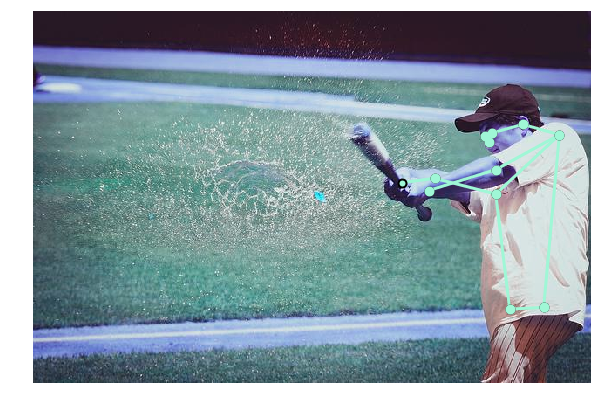

 ------------------- Show real ------------------- 
 -------------- img object -------------- 


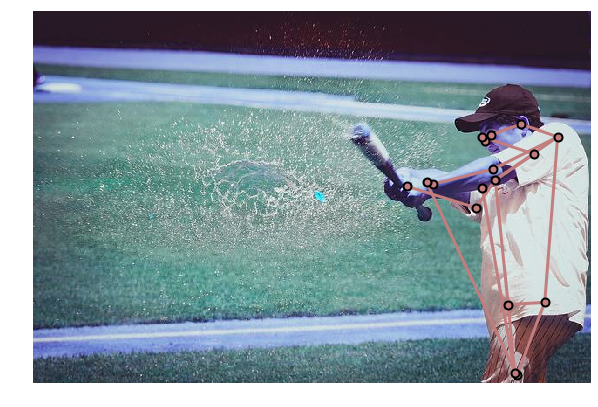

the score is : 2.570249319076538

the precision and recal are :
[ 0.8  1.   1.  -1.   0.8  0.8  1.   1.  -1.   0.8]
 ------------------- Show occ ------------------- 
 -------------- img object -------------- 


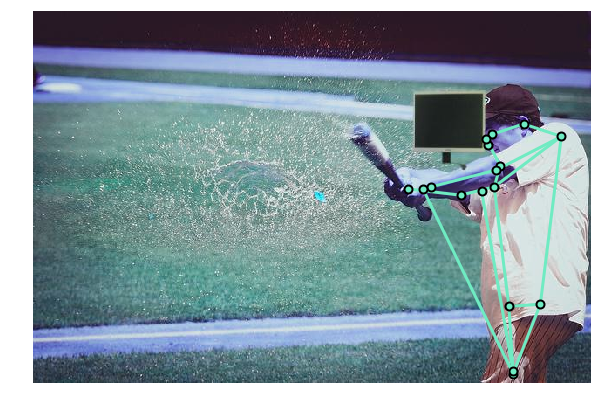

the score is : 2.497122287750244

the precision and recal are :
[ 0.9  1.   1.  -1.   0.9  0.9  1.   1.  -1.   0.9]
 ------------------- Show gen ------------------- 
 -------------- img object -------------- 


KeyboardInterrupt: 

In [42]:
dataDir='datasets/coco'
dataType='val2017'
annFile_full='{}/annotations/instances_{}.json'.format(dataDir,dataType)
annFile_human_pose = '{}/annotations/person_keypoints_{}.json'.format(dataDir,dataType)

# initialize COCO api for instance annotations
coco=COCO(annFile_full)
coco_kps=COCO(annFile_human_pose)

for image_id, data in dataset.items():
    
    for name in ['gt','real', 'occ', 'gen']:
        print(f' ------------------- Show {name} ------------------- ')
        # Real image
        images_dic = data[name]

        # Get the array
        if name == 'gt':
            real_img = data['real']
            arr = cv2.imread(real_img[0])
            new_anns = deepcopy(images_dic)
            new_anns.pop('segmentation', None)

            show_img_and_anno_from_array(arr, [new_anns], coco_kps)
            
            continue
            
        arr = cv2.imread(images_dic[0]) 
        
        # Get annotations
        anns = images_dic[1]
        
        new_anns = deepcopy(anns)
        new_anns.pop('segmentation', None)
        
        # Show images
        show_img_and_anno_from_array(arr, [new_anns], coco_kps)
        
        print(f"the score is : {anns['score']}")
        print()
        print('the precision and recal are :')
        print(images_dic[2])